In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sb
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import QuantileTransformer

In [29]:
import warnings

# Suppressing specific warning
warnings.filterwarnings("ignore", category=FutureWarning)

# Suppressing all warnings
warnings.filterwarnings("ignore")

In [2]:
file_path= r"C:\Users\subha\Desktop\AgriSage\Data\Crop_Recommendation.csv"
raw_data= pd.read_csv (file_path)

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   Phosphorus   2200 non-null   int64  
 2   Potassium    2200 non-null   int64  
 3   Temperature  2200 non-null   float64
 4   Humidity     2200 non-null   float64
 5   pH_Value     2200 non-null   float64
 6   Rainfall     2200 non-null   float64
 7   Crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [4]:
a1 = raw_data.copy()

In [5]:
target = 'Crop'

In [6]:
features = a1.columns[:-1]
features

Index(['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity',
       'pH_Value', 'Rainfall'],
      dtype='object')

## Handling Outliers

The Interquartile Range (IQR) method is a common statistical technique used to identify and handle outliers in a dataset. The IQR is the range between the first quartile (Q1) and the third quartile (Q3) of the dataset.

In [11]:
Q1= a1[features].quantile(0.25)
Q3 = a1[features].quantile(0.75)
IQR = Q3 - Q1 


print('25th percentile of the given data is \n', Q1)
print('75th percentile of the given data is \n', Q3)
print('Interquartile range is\n', IQR)

25th percentile of the given data is 
 Nitrogen       21.000000
Phosphorus     28.000000
Potassium      20.000000
Temperature    22.769375
Humidity       60.261953
pH_Value        5.971693
Rainfall       64.551686
Name: 0.25, dtype: float64
75th percentile of the given data is 
 Nitrogen        84.250000
Phosphorus      68.000000
Potassium       49.000000
Temperature     28.561654
Humidity        89.948771
pH_Value         6.923643
Rainfall       124.267508
Name: 0.75, dtype: float64
Interquartile range is
 Nitrogen       63.250000
Phosphorus     40.000000
Potassium      29.000000
Temperature     5.792279
Humidity       29.686818
pH_Value        0.951950
Rainfall       59.715822
dtype: float64


In [12]:
lower_bound= Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('lower bound of the given data is \n', lower_bound)
print('upper bound of the given data is \n', upper_bound)


lower bound of the given data is 
 Nitrogen      -73.875000
Phosphorus    -32.000000
Potassium     -23.500000
Temperature    14.080956
Humidity       15.731726
pH_Value        4.543768
Rainfall      -25.022047
dtype: float64
upper bound of the given data is 
 Nitrogen       179.125000
Phosphorus     128.000000
Potassium       92.500000
Temperature     37.250073
Humidity       134.478998
pH_Value         8.351567
Rainfall       213.841241
dtype: float64


In [13]:
outliers = (a1[features] < lower_bound) | (a1[features] > upper_bound)

a1_no_outliers = a1[~outliers.any(axis=1)]

a1_no_outliers.reset_index(inplace=True, drop=True)

# Display the cleaned data
a1_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     1768 non-null   int64  
 1   Phosphorus   1768 non-null   int64  
 2   Potassium    1768 non-null   int64  
 3   Temperature  1768 non-null   float64
 4   Humidity     1768 non-null   float64
 5   pH_Value     1768 non-null   float64
 6   Rainfall     1768 non-null   float64
 7   Crop         1768 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 110.6+ KB


In [14]:
a1_no_outliers[target].value_counts()

Crop
Banana         100
Lentil         100
Jute           100
Cotton         100
Muskmelon      100
Watermelon     100
Maize          100
Pomegranate    100
Coffee         100
Blackgram      100
MungBean       100
PigeonPeas     100
KidneyBeans    100
Mango           98
Coconut         85
Orange          83
MothBeans       58
ChickPea        58
Papaya          54
Rice            32
Name: count, dtype: int64

In [15]:
def dist_plot(data, feature_list):
    n_cols= 2 
    n_rows = int(np.ceil(len(feature_list)/n_cols)) 
    # Creating figure
    fig = plt.figure(figsize=(16, 4*n_rows))
    outer = GridSpec(n_rows, n_cols, wspace=0.2, hspace=0.3)

    for i in range(len(feature_list)):
        inner = GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i], 
                                                 wspace=0.1, hspace=0.1, height_ratios=(0.15, 0.85))
        ax_box= plt.Subplot(fig, inner[0])
        sb.boxplot(data=data, x=feature_list[i], color='lightblue', ax=ax_box)
        ax_box.set_xlabel('')
        fig.add_subplot(ax_box)

        mean_value = data[feature_list[i]].mean()
        median_value = data[feature_list[i]].median()
        ax_hist = plt.Subplot(fig, inner[1])
        sb.histplot(data=data, x=feature_list[i], kde=True, ax=ax_hist)
        ax_hist.axvline(mean_value, color='green', linestyle='dotted', linewidth=2, label='Mean')
        ax_hist.axvline(median_value, color='purple', linestyle='dotted', linewidth=2, label='Median')
        ax_hist.legend(loc='lower right', fontsize=10)

        # Calculating skewness and kurtosis
        skewness = data[feature_list[i]].skew()
        kurt = data[feature_list[i]].kurt()
        if skewness < 0:
            x=0.25
        else:
            x=0.95
        # Adding skewness and kurtosis as text on the histogram plot
        ax_hist.text(x, 0.85, f"Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}", 
                         transform=ax_hist.transAxes, verticalalignment='top', horizontalalignment='right',
                         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'),
                    fontsize=10)
        fig.add_subplot(ax_hist)
    plt.tight_layout()
    plt.show(block=False)

C:\Users\subha\AppData\Local\Temp\ipykernel_16180\2722901249.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


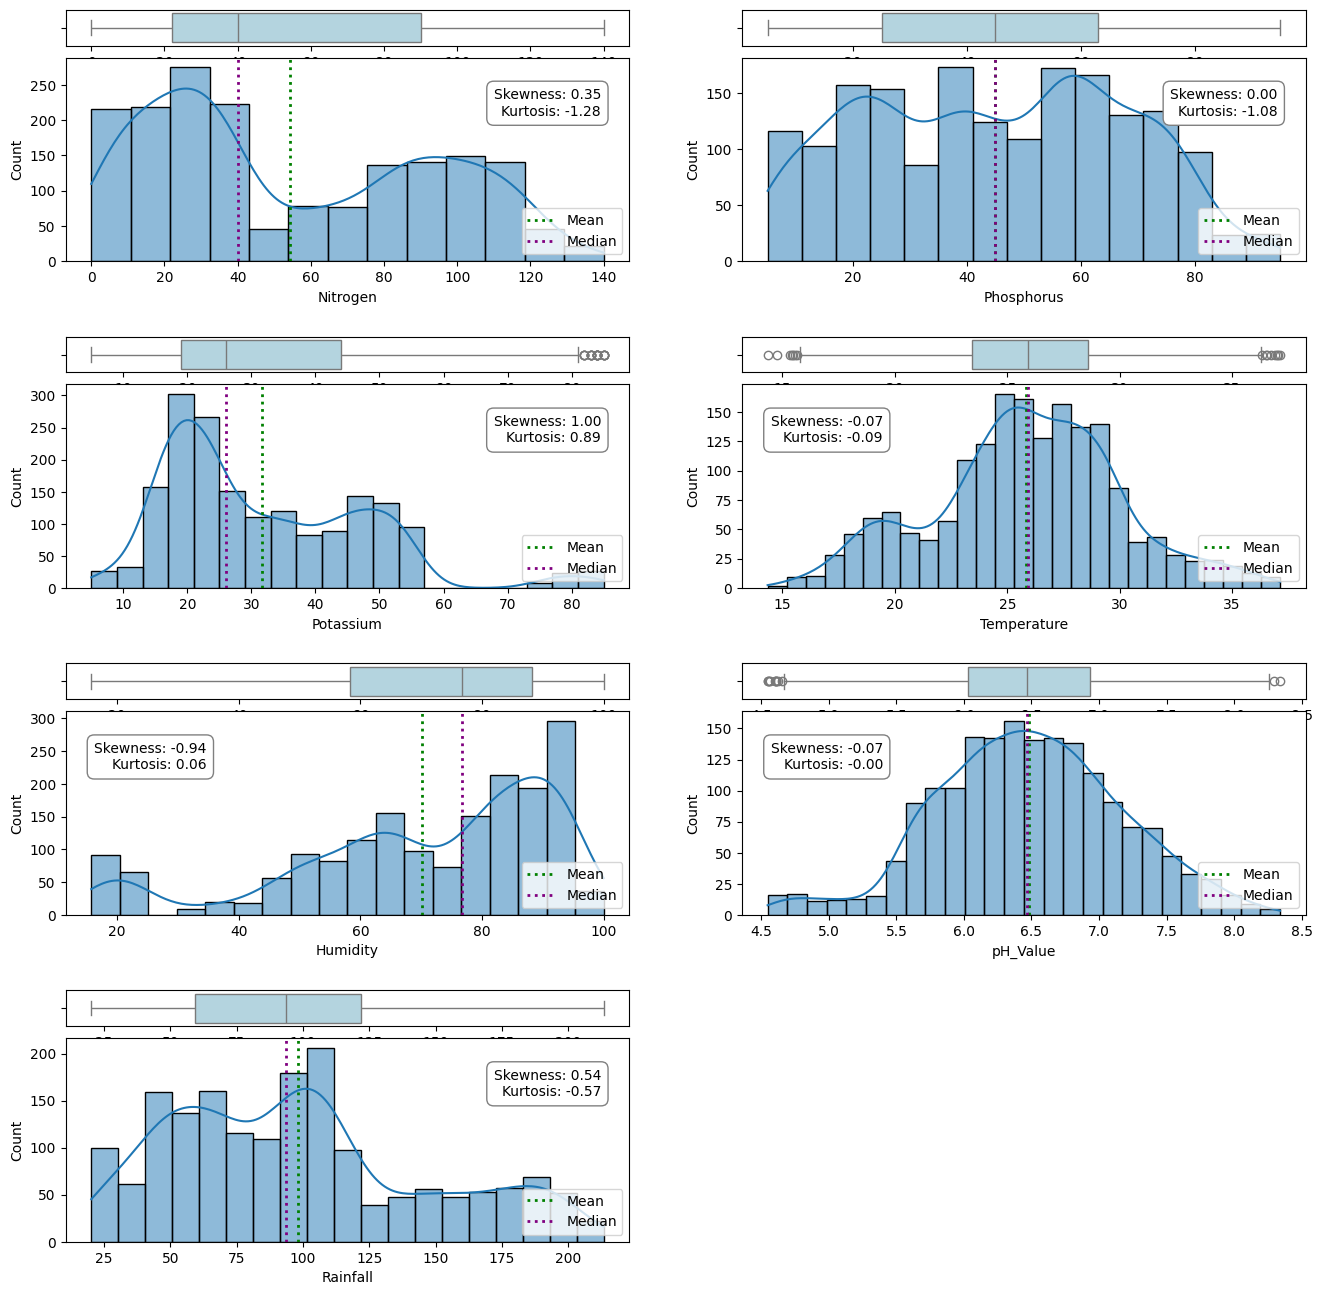

In [15]:
dist_plot(a1_no_outliers, features)

In [16]:
def plot_counts(data, features, hue=None):
    n_cols = 2 
    n_rows = int(np.ceil(len(features)/n_cols)) 

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, feature in enumerate(features):
        #bar_container = axes[i].bar(df[feature].value_counts().index, df[feature].value_counts().values)
        sb.countplot(
        data = data,
        x = feature,
        palette = 'Paired',
        hue = hue,
        ax = axes[i]
        )
        for p in axes[i].patches:
            label = p.get_height()
            x = p.get_x() + p.get_width() / 2 # Width of the plot
            y = p.get_height() # Height of the plot
            
            rotation = 0
            if hue is not None:
                rotation = 30  # Rotate annotations by 30 degrees if hue is not None

    axes[i].annotate(
        '{:.0f}'.format(label),
        (x, y),
        ha = 'center',
        va = 'center',
        size = 12,
        xytext = (0, 5),
        textcoords = 'offset points',
        rotation = rotation
    )
    axes[i].set(ylabel='Count', title=feature, xlabel='')
    axes[i].tick_params(axis='x', rotation=30)

    # If the number of features is odd, remove the empty subplot
    if len(features) % 2 != 0:
        fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

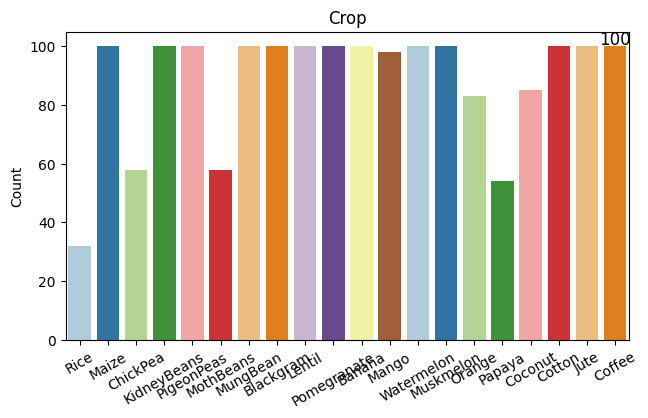

In [30]:
plot_counts(a1_no_outliers, [target])

In [18]:
print (a1.head())

   Nitrogen  Phosphorus  Potassium  Temperature   Humidity  pH_Value  \
0        90          42         43    20.879744  82.002744  6.502985   
1        85          58         41    21.770462  80.319644  7.038096   
2        60          55         44    23.004459  82.320763  7.840207   
3        74          35         40    26.491096  80.158363  6.980401   
4        78          42         42    20.130175  81.604873  7.628473   

     Rainfall  Crop  
0  202.935536  Rice  
1  226.655537  Rice  
2  263.964248  Rice  
3  242.864034  Rice  
4  262.717340  Rice  


Transformed Data:
   Nitrogen  Phosphorus  Potassium  Temperature  Humidity  pH_Value  \
0        91    1.318462   1.324738     1.111456  1.483138  6.502985   
1        86    1.401292   1.311994     1.125109  1.478421  7.038096   
2        61    1.388126   1.330832     1.142849  1.484016  7.840207   
3        75    1.268453   1.305323     1.186870  1.477963  6.980401   
4        79    1.318462   1.318462     1.099352  1.482034  7.628473   

     Rainfall  Crop  Log_Nitrogen  Sqrt_Nitrogen  BoxCox_Nitrogen  \
0  202.935536  Rice      4.499810       9.486833        13.271436   
1  226.655537  Rice      4.442651       9.219544        12.907666   
2  263.964248  Rice      4.094345       7.745967        10.871298   
3  242.864034  Rice      4.304065       8.602325        12.061289   
4  262.717340  Rice      4.356709       8.831761        12.376970   

   YeoJohnson_Nitrogen  Quantile_Nitrogen  
0            12.444419           0.807429  
1            12.119878           0.684763  
2       

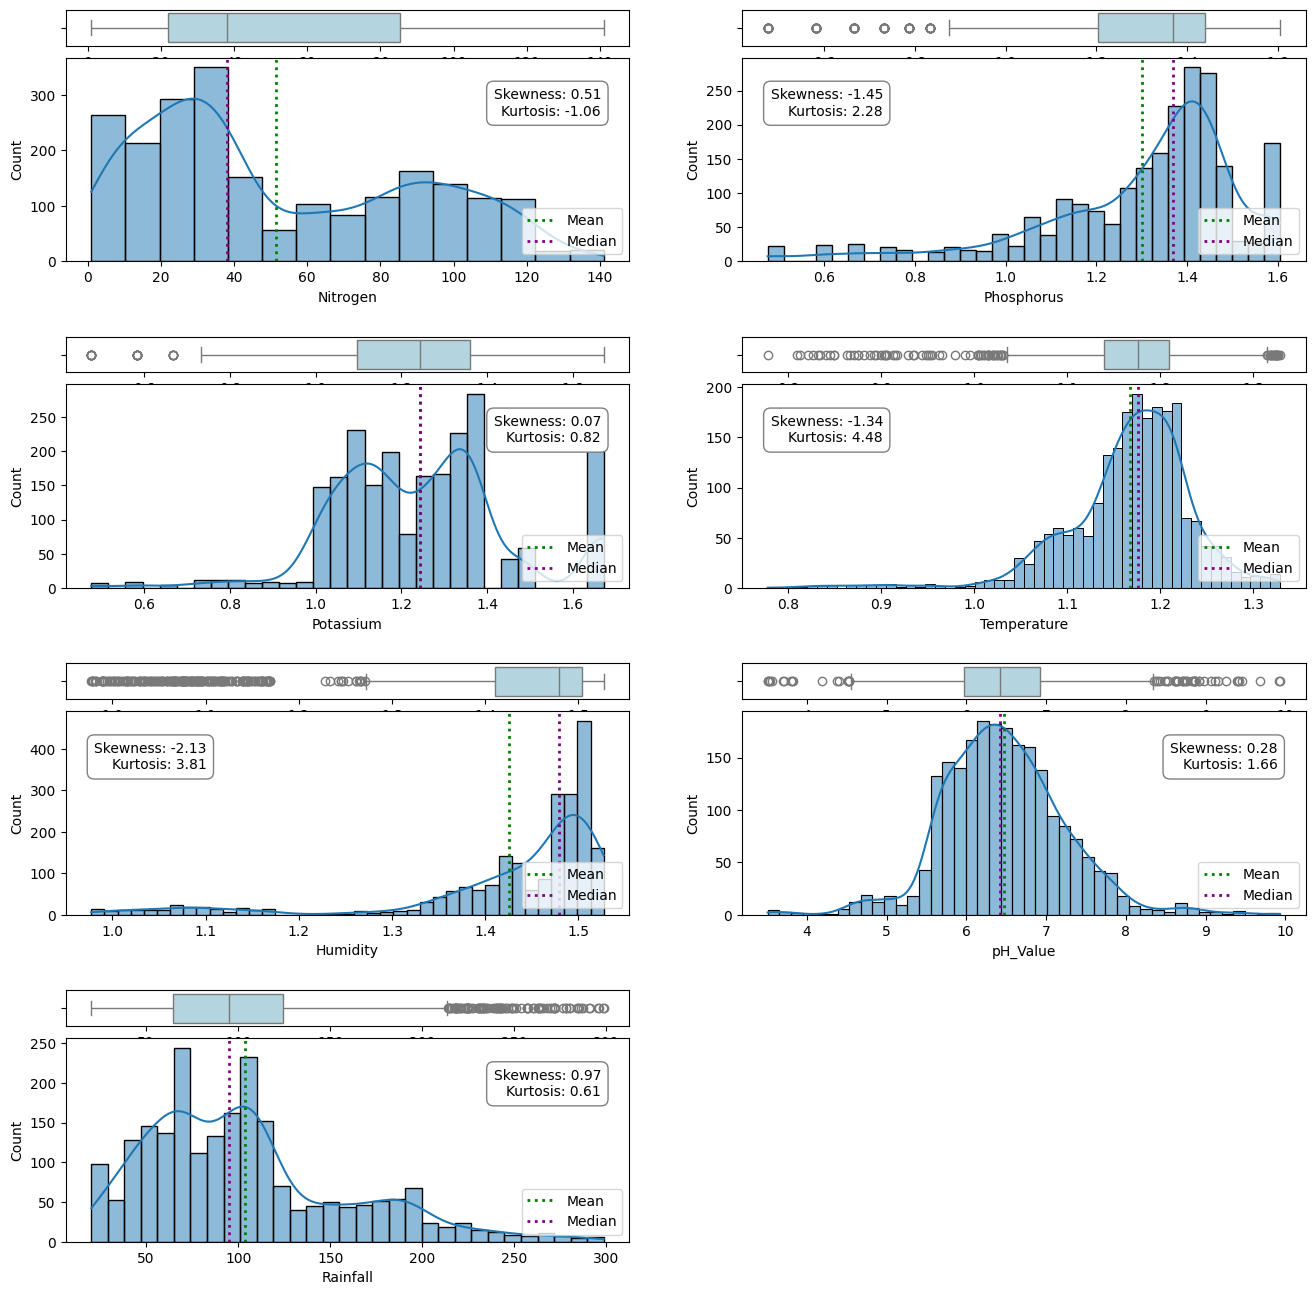

In [31]:
columns_to_transform = ['Potassium','Phosphorus','Temperature','Humidity']
# Replace zeros with a small number (e.g., 1e-6) or filter them out
a1[columns_to_transform] = a1[columns_to_transform].replace(0, np.nan)
a1[columns_to_transform] = a1[columns_to_transform].apply(np.log)
# Display the first few rows of the transformed dataset
print("Transformed Data:")
print(a1.head())
dist_plot(a1, features)

In [27]:
def transformation_method(data, feature):
    fig, axes = plt.subplots(2, 3, figsize=(12, 9))  # Adjusted for an additional plot

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Hide unused subplot axes
    for ax in axes[6:]:
        ax.axis('off')
        
    # Calculate skewness
    # Original Distribution of the feature
    sb.histplot(data[feature], kde=True, bins=30, palette='viridis', ax=axes[0])
    axes[0].set_title(f'Original {feature} Distribution \n (Skew: {data[feature].skew():.5f})', fontsize=10)
    axes[0].set_xlabel(feature, fontsize=10)
    axes[0].set_ylabel('Frequency', fontsize=10)

    # Log Transformed feature
    data['Log_'+feature] = np.log(data[feature])
    sb.histplot(data['Log_'+feature], kde=True, bins=30, color='orange', ax=axes[1])
    axes[1].set_title(f"Log Transformed {feature} \n (Skew: {data['Log_'+feature].skew():.5f})", fontsize=10)
    axes[1].set_xlabel(f'Log of {feature}', fontsize=10)
    axes[1].set_ylabel('Frequency', fontsize=10)

    # Square Root Transformed feature
    data['Sqrt_'+feature] = np.sqrt(data[feature])
    sb.histplot(data['Sqrt_'+feature], kde=True, bins=30, color='blue', ax=axes[2])
    axes[2].set_title(f"Square Root Transformed {feature} \n (Skew: {data['Sqrt_'+feature].skew():.5f})", fontsize=10)
    axes[2].set_xlabel(f'Square Root of {feature}', fontsize=10)
    axes[2].set_ylabel('Frequency', fontsize=10)
    
    # Box-Cox Transformed feature
    # Applying Box-Cox Transformation after checking all values are positive
    if (data[feature] <= 0).any():
        # Shift the values to make them positive
        shift_value = abs(data[feature].min()) + 1
        data[feature] += shift_value
        print(f"Values of {feature} were shifted to make them positive.")
    data['BoxCox_'+feature], _ = boxcox(data[feature])
    sb.histplot(data['BoxCox_'+feature], kde=True, bins=30, color='red', ax=axes[3])
    axes[3].set_title(f"Box-Cox Transformed {feature} \n Skew: {data['BoxCox_'+feature].skew():.5f})", fontsize=10)
    axes[3].set_xlabel(f'Box-Cox of {feature}', fontsize=10)
    axes[3].set_ylabel('Frequency', fontsize=10)

    # Yeo-Johnson Transformed feature
    # Applying Yeo-Johnson Transformation
    data['YeoJohnson_'+feature], _ = yeojohnson(data[feature])
    sb.histplot(data['YeoJohnson_'+feature], kde=True, bins=30, color='purple', ax=axes[4])
    axes[4].set_title(f"Yeo-Johnson Transformed {feature} \n (Skew: {data['YeoJohnson_'+feature].skew():.5f})", fontsize=10)
    axes[4].set_xlabel(f'Yeo-Johnson of {feature}', fontsize=10)
    axes[4].set_ylabel('Frequency', fontsize=10)

    # Quantile Transformed feature (Normal Distribution)
    # Applying Quantile Transformation to follow a normal distribution
    quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
    data['Quantile_'+feature] = quantile_transformer.fit_transform(data[feature].values.reshape(-1, 1)).flatten()
    sb.histplot(data['Quantile_'+feature], kde=True, bins=30, color='green', ax=axes[5])
    axes[5].set_title(f"Quantile Transformed {feature} (Normal Distn, \n Skew: {data['Quantile_'+feature].skew():.5f})", fontsize=10)
    axes[5].set_xlabel(f'Quantile Transformed {feature}', fontsize=10)
    axes[5].set_ylabel('Frequency', fontsize=10)


    plt.tight_layout(pad=3.0)
    plt.show()



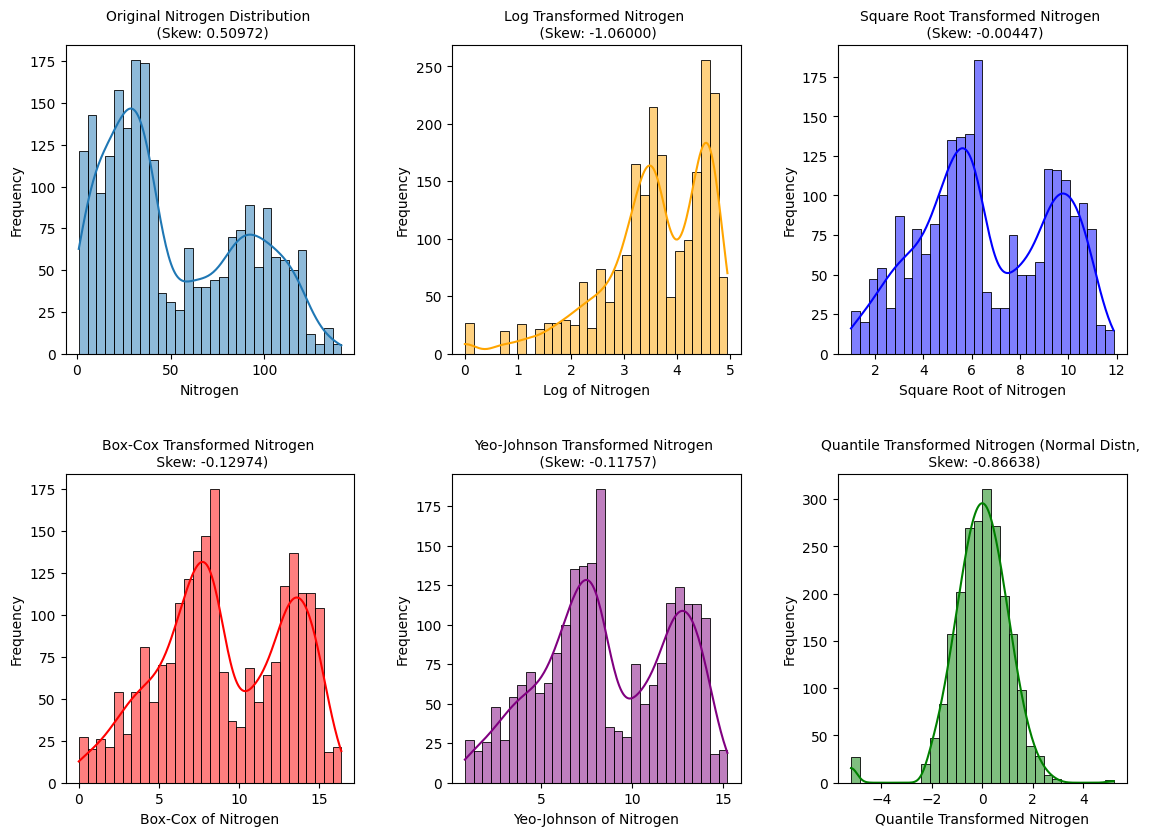

In [32]:
transformation_method(a1, features[0])

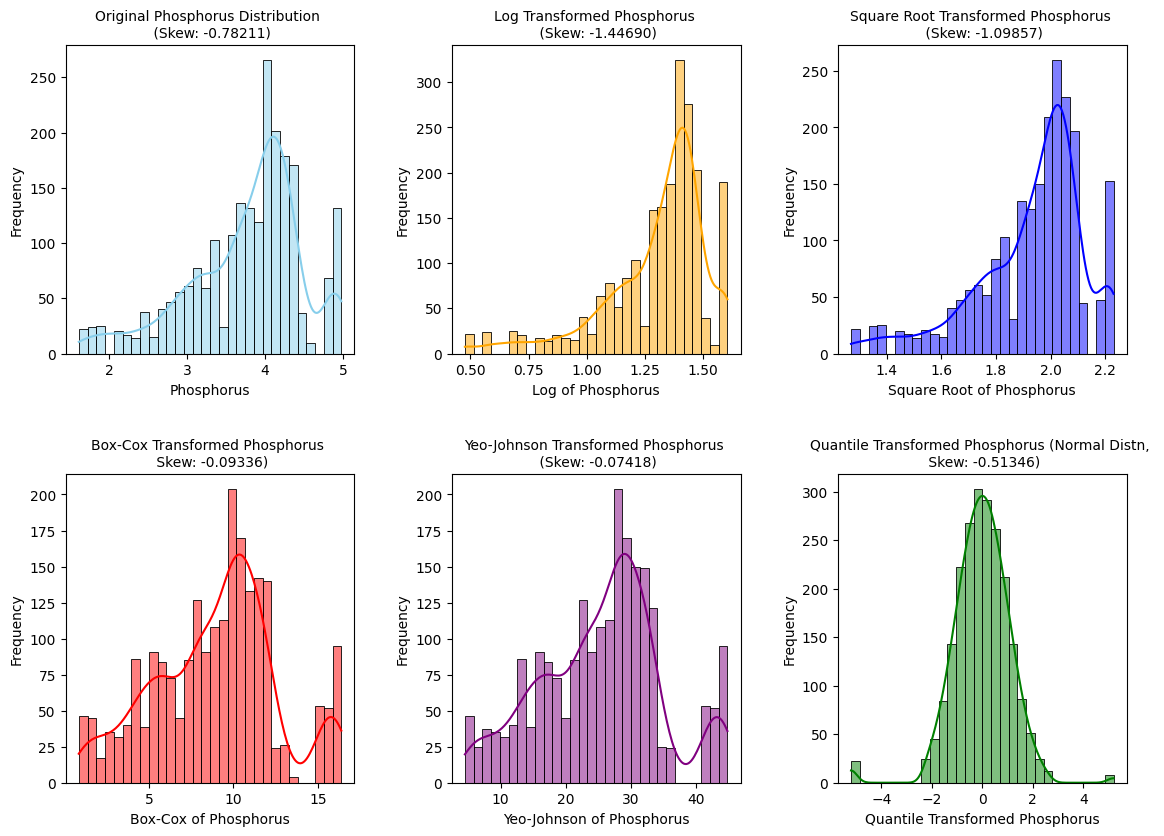

In [ ]:
transformation_method(a1, features[1])

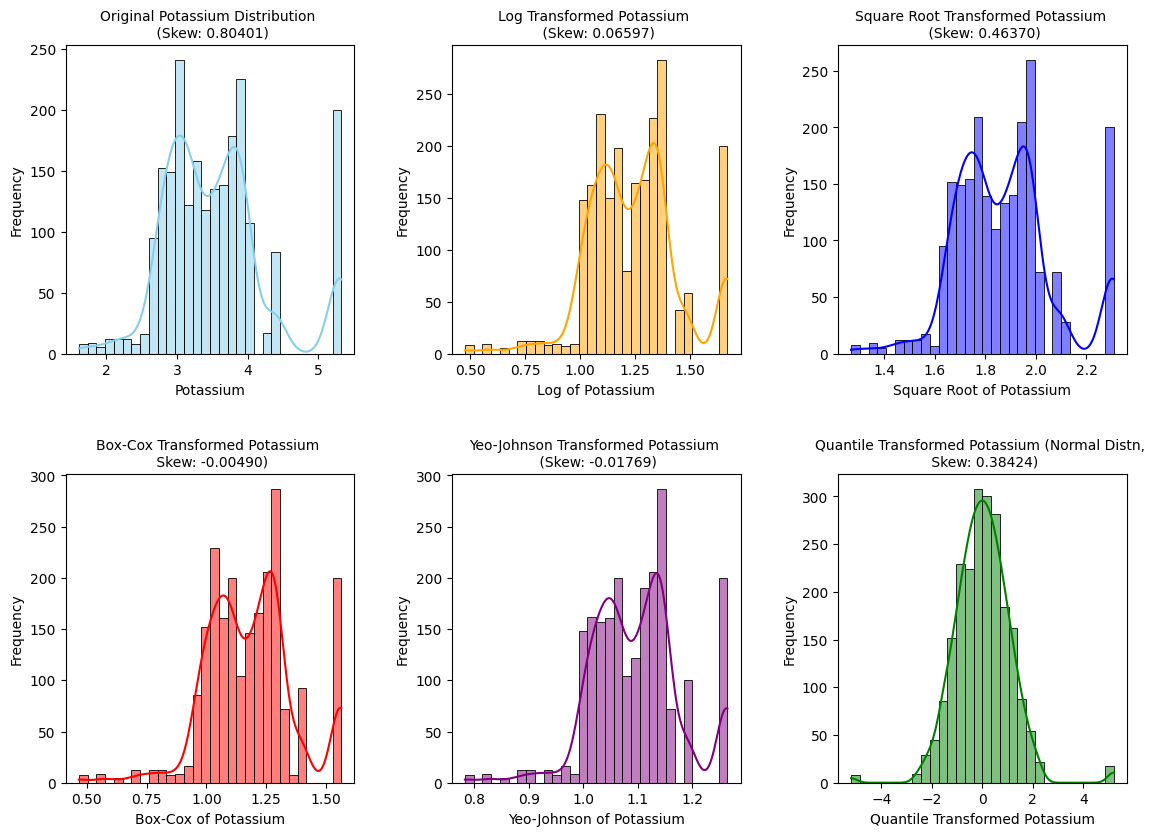

In [ ]:
transformation_method(a1, features[2])

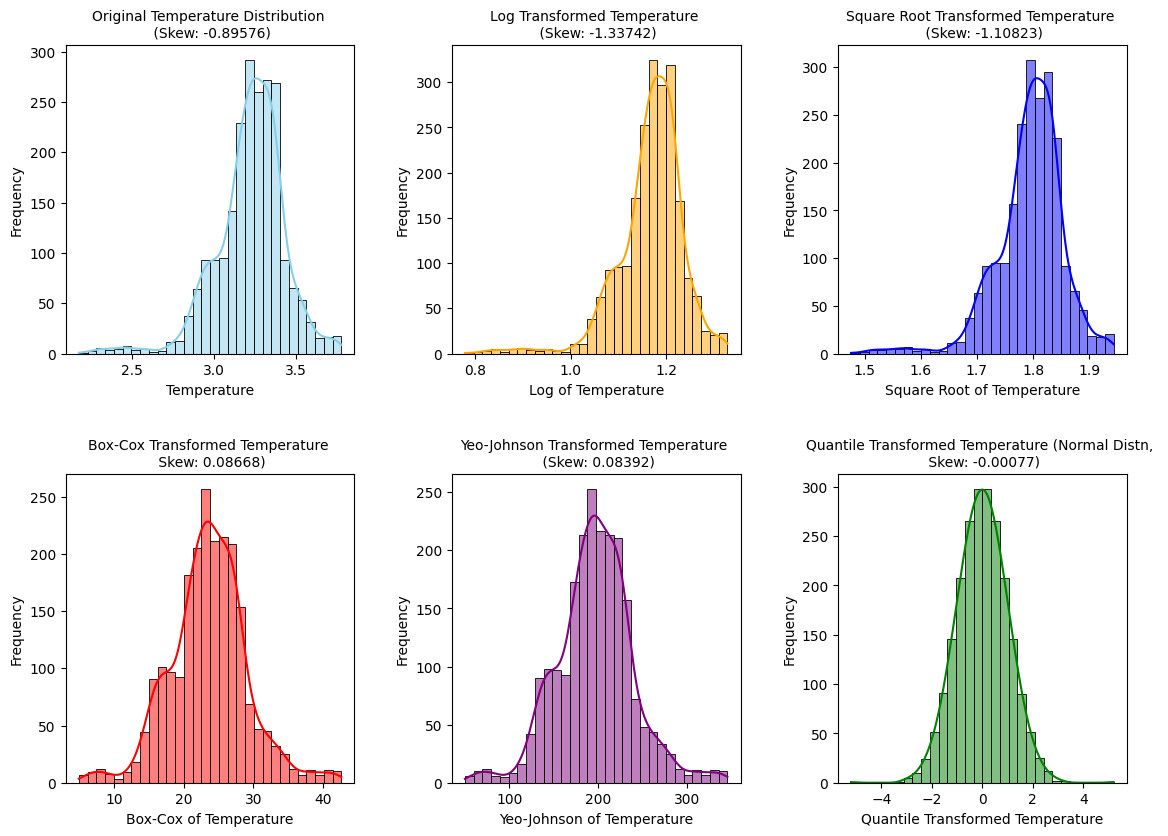

In [ ]:
transformation_method(a1, features[3])

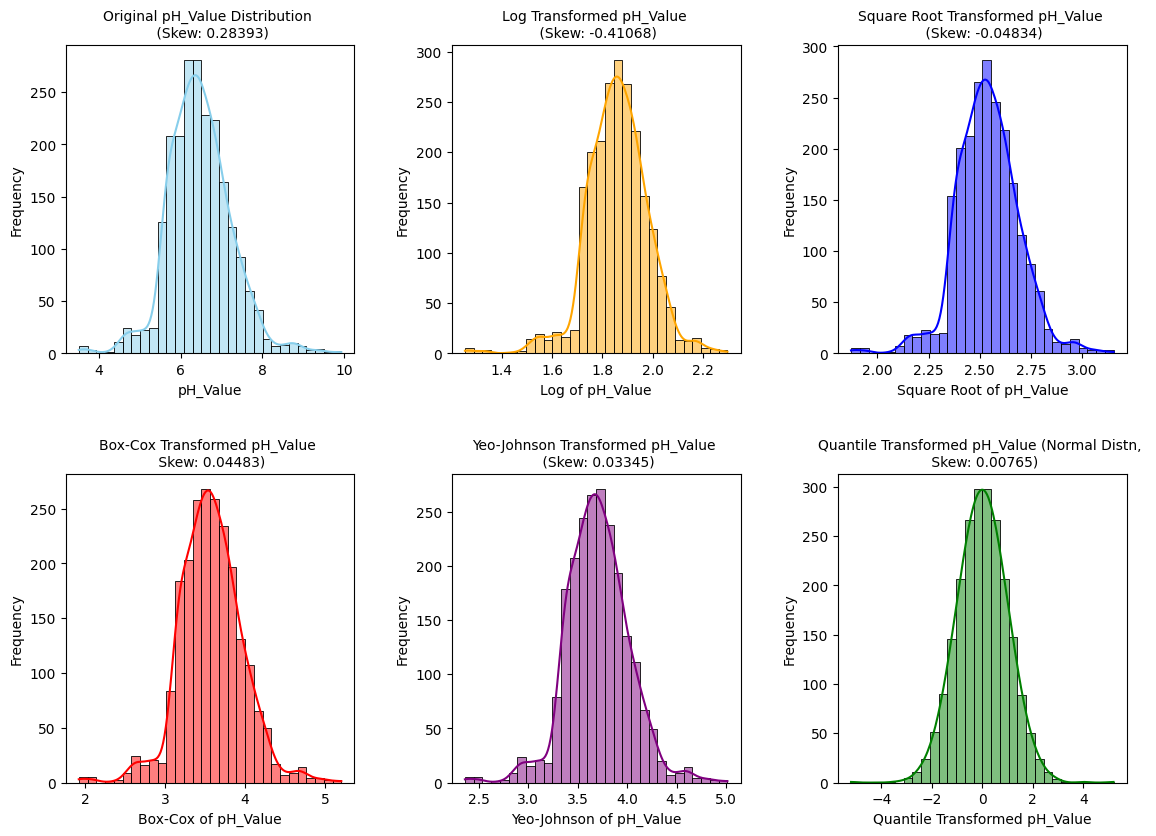

In [ ]:
transformation_method(a1, features[5])

In some of the graphs above, we see that some transformations result in double peaks. This might indicate that crops might be devided in two groups for each feature. To understand this assumption of ours, we can graphs that show crops vs features, i.e. how different crops behave to different values of features.

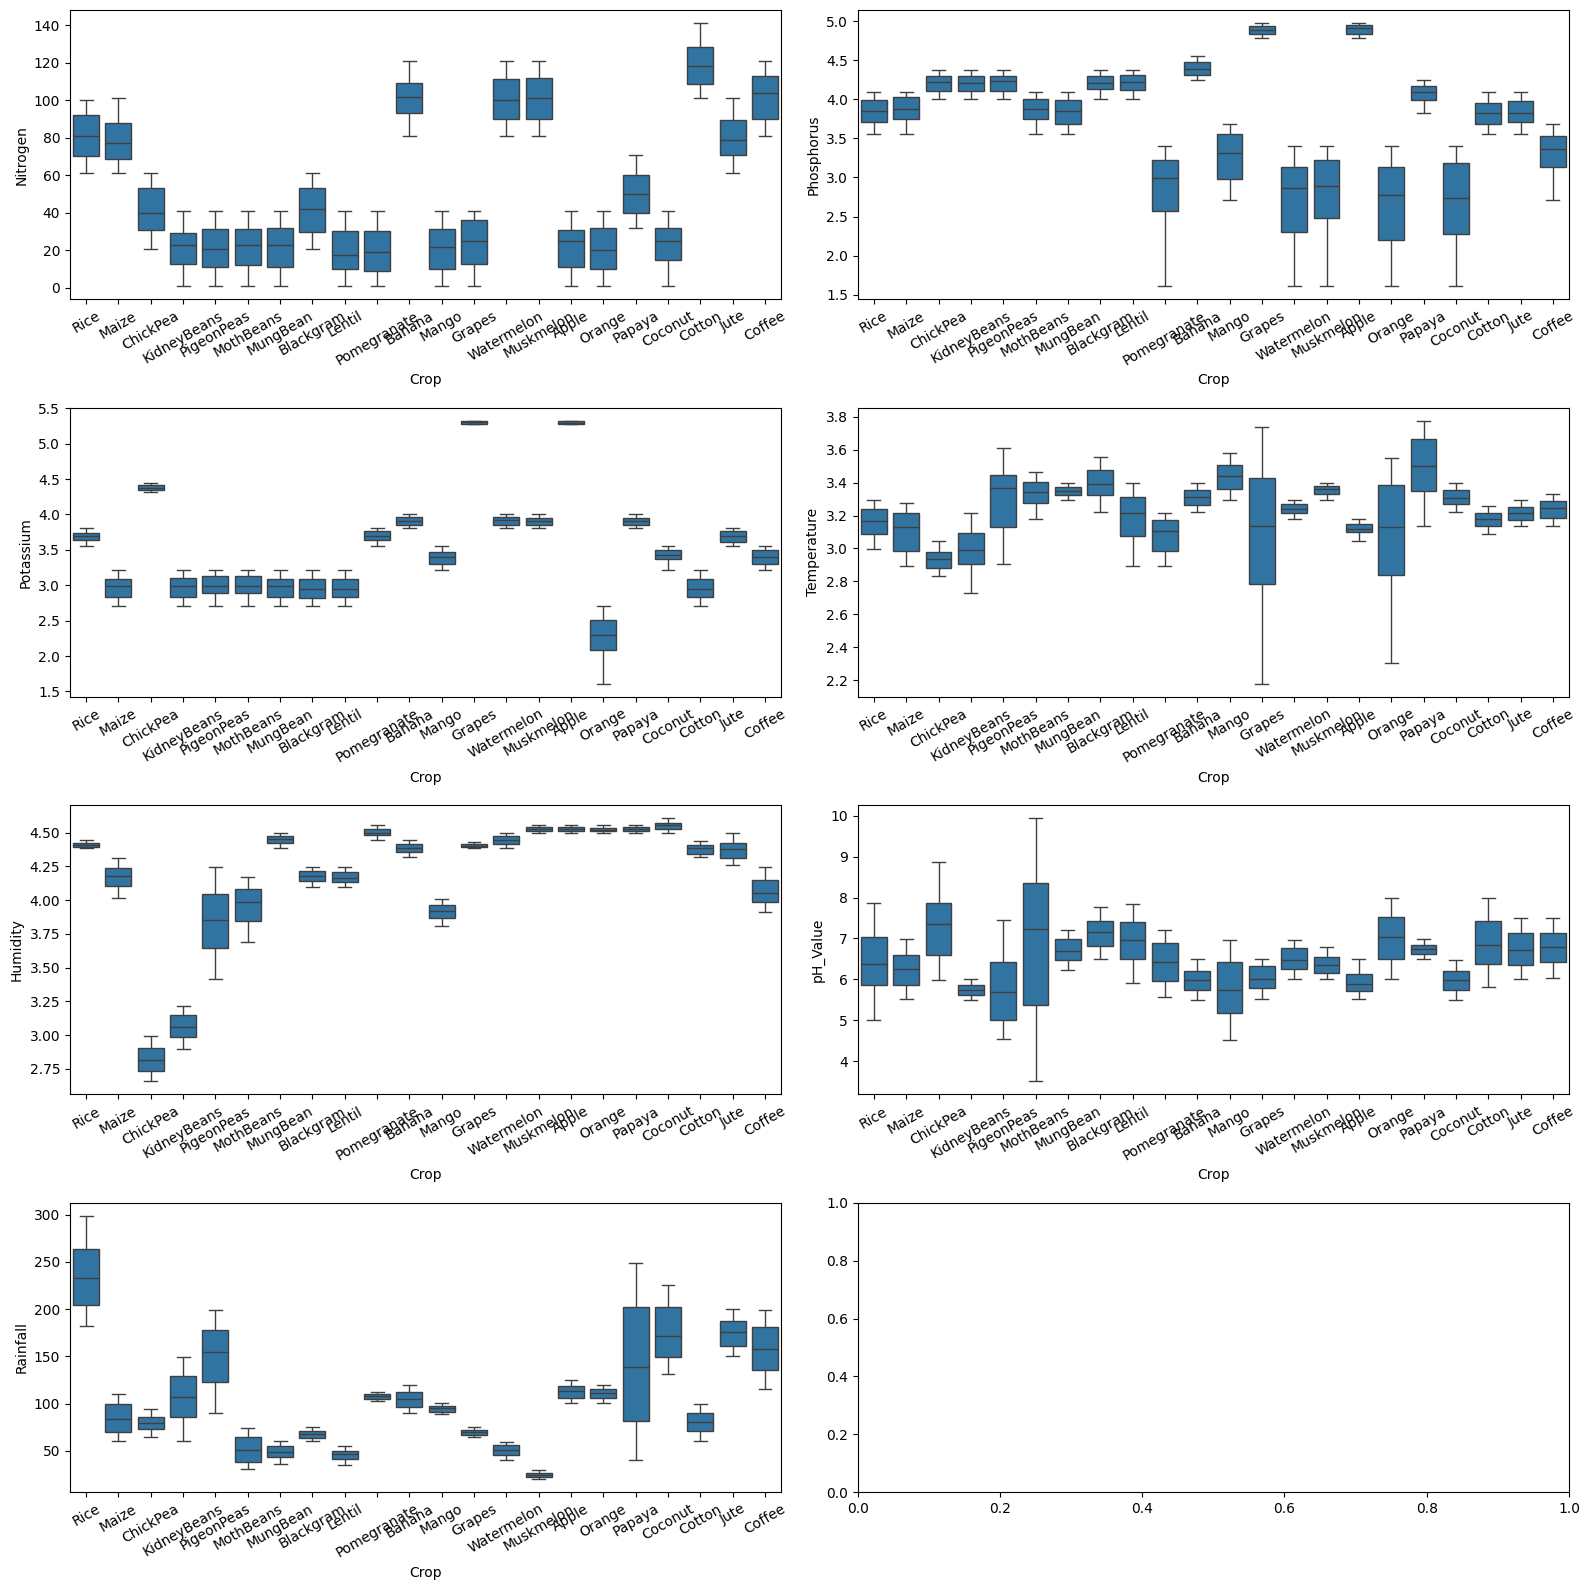

In [ ]:
n_cols = 2
n_rows = 4
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
ax = ax.flatten()

for i, feature in enumerate(features):
    sb.boxplot(data=a1, x=target, y=feature,ax=ax[i] )
    ax[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show(block=False)

From the above box plots it is now clear to us that crops are be divided into to groups for certain features. 
For example, the Box-Cox transformation and Yeo-Johnson transformation for Nitrogen shows two peaks. This is further confirmed from the box plot above where almost half of the crops reuire low nitrogen and the other half requires high nitrogen. 
This is also the case for certain other features like Potassium and Phosphorus. 